# Retrain stardist

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import imageio
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# !pip install csbdeep
# !pip install stardist
# !pip install gputools
# !pip install scikit-tensor-py3

# import gputools
from glob import glob
from tqdm import tqdm
from tifffile import imread
import csbdeep
from csbdeep.utils import Path, download_and_extract_zip_file

from stardist import fill_label_holes, relabel_image_stardist, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

import cv2
import os

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import Model, layers, models

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator

from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import Iterator, ImageDataGenerator
import tensorflow.keras.backend as K

print(tf.__version__)
print(tf.test.is_built_with_cuda()) 
print(tf.config.list_physical_devices('GPU'))

import skimage.transform

from PIL import Image

# tf.config.gpu.set_per_process_memory_fraction(0.80)
# tf.config.gpu.set_per_process_memory_growth(True)

np.random.seed(42)
lbl_cmap = random_label_cmap()

2.2.0
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
def preprocess(imgs, target_shape=(512, 512), normalize=True, axis_norm=(0, 1)):
    
#     assert len(imgs.shape) == 4  # batch preprocessing only
    
    # perf reshape
    if target_shape != (imgs.shape[1], imgs.shape[2]):
        bat = []
        for im in imgs:
#             resized = skimage.transform.resize(img, target_shape)
            resized = cv2.resize(im, target_shape, 0, 0, interpolation=cv2.INTER_NEAREST)
            bat.append(resized)
        imgs = np.array(bat)
        
    if normalize:
        bat = []
        for im in imgs:
            bat.append( (im - im.min(axis=(0, 1))) / (im.max(axis=(0, 1)) - im.min(axis=(0, 1))) )
        imgs = np.array(bat)
        
    return imgs

def random_fliprot(img, mask): 
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim))) 
    mask = mask.transpose(perm) 
    for ax in axes: 
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask 

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augment(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

def visualize_data(bf, masks, nc_ims=1, nc_masks=1):
    viewer = napari.Viewer()
    if nc_ims == 1:
        viewer.add_image(bf[:, :, :])
    else:
        for k in range(nc_ims):
            viewer.add_image(bf[:, :, :, k], blending="additive")
    
    viewer.add_image(masks[:, :, :], blending="additive")

Target shape: (512, 512)
Normalize images: True.
Loaded data.
Filled label holes.
(30, 512, 512) (30, 512, 512)
(10, 512, 512) (10, 512, 512)
(54, 512, 512) (54, 512, 512)


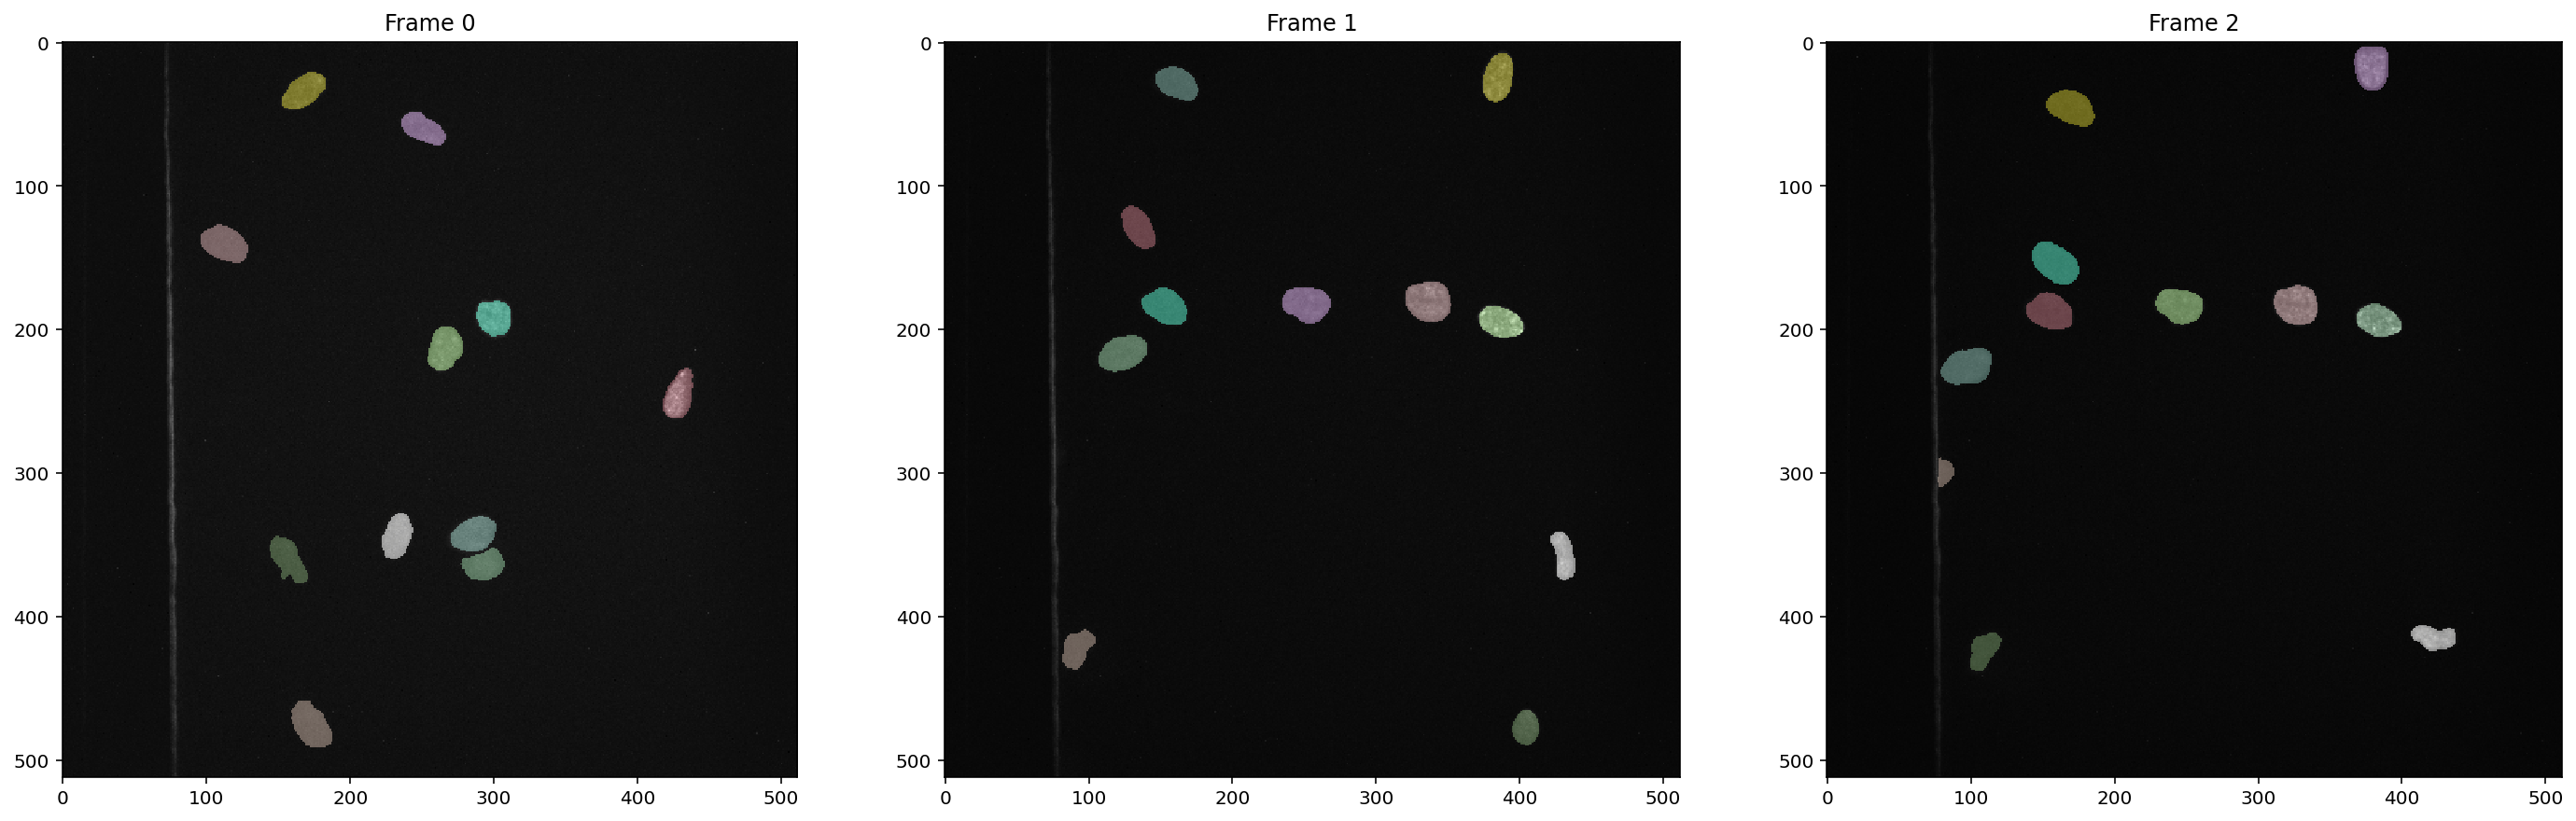

In [26]:
data_path = "D:/Hugo/Migration/"
train_bf_dir, train_mask_dir = sorted(glob(f"{data_path}/Train_Set/images/*.tif")), sorted(glob(f"{data_path}/Train_Set/masks_dense/*.tif"))
val_bf_dir, val_mask_dir = sorted(glob(f"{data_path}/Validation_Set/images/*.tif")), sorted(glob(f"{data_path}/Validation_Set/masks_dense/*.tif"))
test_bf_dir, test_mask_dir = sorted(glob(f"{data_path}/Position1/*.tif")), sorted(glob(f"{data_path}/Position1/*.tif"))

target_dim, normalize_ims = (512, 512), True

print(f"Target shape: {target_dim}")
print(f"Normalize images: {normalize_ims}.")

X_train, Y_train = preprocess(np.array(list(map(imageio.imread, train_bf_dir))), target_shape=target_dim, normalize=True),  preprocess(np.array(list(map(imread, train_mask_dir))), target_shape=target_dim, normalize=False)
X_val, Y_val =  preprocess(np.array(list(map(imageio.imread, val_bf_dir))), target_shape=target_dim, normalize=True),  preprocess(np.array(list(map(imread, val_mask_dir))), target_shape=target_dim, normalize=False)
X_test, Y_test =  preprocess(np.array(list(map(imageio.imread, test_bf_dir))), target_shape=target_dim, normalize=True),  preprocess(np.array(list(map(imread, test_mask_dir))), target_shape=target_dim, normalize=False)

print("Loaded data.")

Y_train = np.array([fill_label_holes(y) for y in Y_train])
Y_val = np.array([fill_label_holes(y) for y in Y_val])
Y_test = np.array([fill_label_holes(y) for y in Y_test])

print("Filled label holes.")

print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)
            
plot = True
if plot:    
    init_frame, nb_ims = 0, 3
    fig, axes = plt.subplots(1, nb_ims, figsize=(8 * nb_ims, 8))

    for i, (im, ms, ax) in enumerate(zip(X_train[init_frame:], Y_train[init_frame:], axes)):
        ax.imshow(im, cmap="gray")
        ax.imshow(ms, cmap=lbl_cmap, alpha=0.5)
        ax.set_title(f"Frame {i}")


In [28]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Predict on subsampled grid for increased efficiency and larger field of view
grid = (2, 2)

conf = Config2D (n_rays=n_rays, grid=grid, use_gpu=False, n_channel_in=1, train_shape_completion=False)

print(conf)
vars(conf)

Config2D(axes='YXC', backbone='unet', grid=(2, 2), n_channel_in=1, n_channel_out=33, n_classes=None, n_dim=2, n_rays=32, net_conv_after_unet=128, net_input_shape=(None, None, 1), net_mask_shape=(None, None, 1), train_background_reg=0.0001, train_batch_size=4, train_checkpoint='weights_best.h5', train_checkpoint_epoch='weights_now.h5', train_checkpoint_last='weights_last.h5', train_class_weights=(1, 1), train_completion_crop=32, train_dist_loss='mae', train_epochs=400, train_foreground_only=0.9, train_learning_rate=0.0003, train_loss_weights=(1, 0.2), train_n_val_patches=None, train_patch_size=(256, 256), train_reduce_lr={'factor': 0.5, 'patience': 40, 'min_delta': 0}, train_sample_cache=True, train_shape_completion=False, train_steps_per_epoch=100, train_tensorboard=True, unet_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_kernel_size=(3, 3), unet_last_activation='relu', unet_n_conv_per_depth=2, unet_n_depth=3, unet_n_filter_base=32, unet_pool=(2, 2), unet_prefix='', 

{'n_dim': 2,
 'axes': 'YXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2),
 'backbone': 'unet',
 'n_classes': None,
 'unet_n_depth': 3,
 'unet_kernel_size': (3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, 1),
 'net_mask_shape': (None, None, 1),
 'train_shape_completion': False,
 'train_completion_crop': 32,
 'train_patch_size': (256, 256),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae',
 'train_loss_weights': (1, 0.2),
 'train_class_weights': (1, 1),
 'train_epochs': 400,
 'train_steps_per_epoch': 100,
 'train_learning_rate': 0.0003,


base_model.py (148): output path for model already exists, files may be overwritten: D:\Hugo\Migration\Models\MigSd_150


Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/150
100/100 [==============================] - 5s 47ms/step - loss: 1.7529 - prob_loss: 0.2078 - dist_loss: 7.7254 - prob_kld: 0.1730 - dist_relevant_mae: 7.7248 - dist_relevant_mse: 96.3083 - dist_dist_iou_metric: 0.2355 - val_loss: 1.1616 - val_prob_loss: 0.0871 - val_dist_loss: 5.3725 - val_prob_kld: 0.0679 - val_dist_relevant_mae: 5.3716 - val_dist_relevant_mse: 47.8097 - val_dist_dist_iou_metric: 0.3728 - lr: 3.0000e-04
Epoch 2/150
100/100 [==============================] - 4s 43ms/step - loss: 1.1053 - prob_loss: 0.0724 - dist_loss: 5.1646 - prob_kld: 0.0558 - dist_relevant_mae: 5.1635 - dist_relevant_mse: 42.5228 - dist_dist_iou_metric: 0.4209 - val_loss: 1.1518 - val_prob_loss: 0.0812 - val_dist_loss: 5.3531 - val_prob_kld: 0.0620 - val_dist_relevant_mae: 5.3521 - val_dist_relevant_mse: 47.5912 - val_dist_dist_iou_metric: 0.3716 - lr: 3.0000e-04
Epoch 3/150
100/100 [==============================] - 4s 40ms/step - l

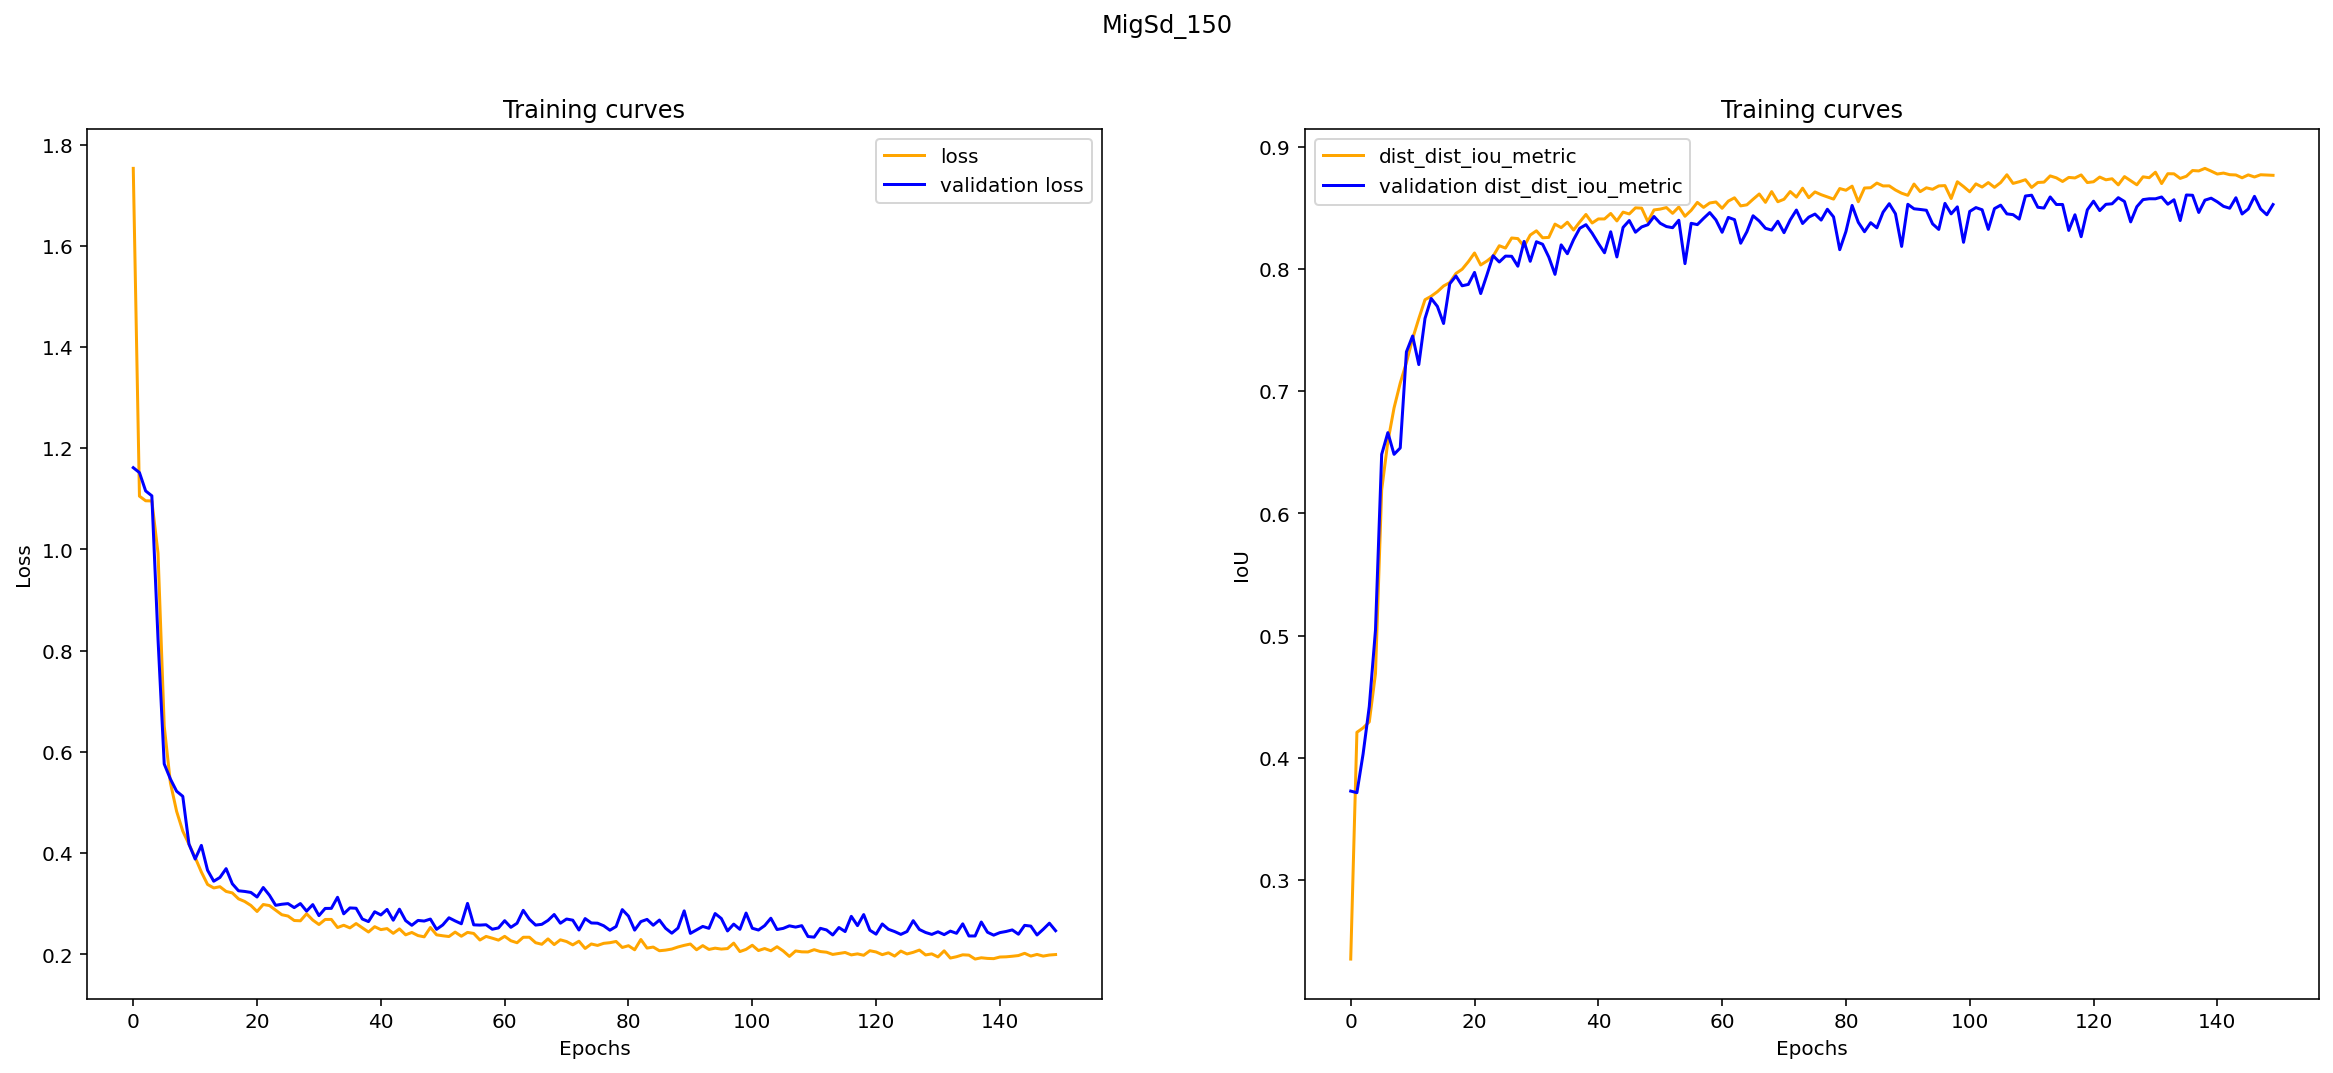

In [31]:
os.chdir(f"{data_path}/Models")
n_epochs = 150
model_name = f"MigSd_{n_epochs}"

if not os.path.isdir(model_name):
    os.mkdir(model_name)
else:
    print("Model dir already exists. It will be overwritten after the training step.")

model = StarDist2D(conf, name=f"{model_name}", basedir=".")

# tain the model
history = model.train(X_train, Y_train, validation_data=(X_val, Y_val), augmenter=augment, epochs=n_epochs)

# plot learning curves
fig, ax = plt.subplots(1, 2, figsize=(20, 8))
ax[0].plot(history.history["loss"][:], "orange", label="loss")
ax[0].plot(history.history["val_loss"][:], "b", label="validation loss")
ax[0].legend()
ax[0].set_title("Training curves")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel(f"Loss")

metrics_name = "dist_dist_iou_metric"

ax[1].plot(history.history[metrics_name][:], "orange", label=metrics_name)
ax[1].plot(history.history[f"val_{metrics_name}"][:], "b", label=f"validation {metrics_name}")
ax[1].legend()
ax[1].set_title("Training curves")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("IoU")

# save model
fig.suptitle(model_name)
# model.keras_model.save(f"{model_name}")
model.export_TF(f"{model_name}")  # save the model as SavedModel tensorflow format. To load it : models = Stardist2D(None, name="path")

plt.savefig(f"{model_name}/{model_name}_learning_curve.png")

list_training_imgs = "\n".join(train_bf_dir)
list_val_imgs = "\n".join(val_bf_dir)

with open(f"{model_name}/history.txt", "w") as hist_file:
    hist_file.write(f"Model {model_name} trained for {n_epochs} epochs."
                    f"\n\nNumber of training images : {X_train.shape[0]}."
                    f"\n\nNumber of validation images : {X_val.shape[0]}."
                    f"\n\nLoss : Stardist loss (sum of KL div and MAE)" #, smoothing: {smooth}."
                    # f"\n\nConfiguration : {vars(conf)}"
                    f"\n\nList of the training images:\n{list_training_imgs}."
                    f"\n\nList of the validation images:\n{list_val_imgs}."
                   )

# Make predictions

In [42]:
test_bf_dir = "D:\Hugo\Migration\Position2/"

test_imgs = []
for im in os.listdir(test_bf_dir):
    test_imgs.append(imageio.imread(f"{test_bf_dir}/{im}"))
test_imgs = np.array(test_imgs)

print(test_imgs.shape)
    
# X_test = preprocess(imageio.volread(test_bf_dir))
X_test = preprocess(test_imgs)

print(X_test.shape)

(54, 2048, 2048)
(54, 512, 512)


In [43]:
predictions = []
for im in X_test:
    label, _ = model.predict_instances(im)
    predictions.append(label)

predictions = np.array(predictions)

In [44]:
import napari

viewer = napari.view_image(X_test)
viewer.add_image(predictions)

<Image layer 'predictions' at 0x1c61c922cd0>

In [45]:
save_path = "D:\Hugo\Migration\Predictions/MigSd150_Position2.tif"
imageio.volwrite(save_path, predictions)